# Multidimensional Motif Discovery

## Finding a Motif in Multidimensional Time Series Data with MSTUMP

This example utilizes the main takeways from the [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf) research paper. For proper context, we highly recommend that you read the paper first but know that our implementations follow this paper closely.

To demonstrate the API and underlying principles, we will be looking at a simple toy dataset and will be seeing if we can identify a motif in multidimensional time series data. This is the same data that is presented throughout the original paper (above).

## Getting Started

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import urllib
import ssl
import io

The python functions below are going to be used throughout this example to automatically resize and create the plots that are displayed using the Matplotlib python plotting package.

In [2]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size

change_plot_size(20, 6, plt)

## Retrieve the Data

In [3]:
context = ssl.SSLContext()
url = "https://github.com/mcyeh/mstamp/blob/master/Python/toy_data.mat?raw=true"
raw_bytes = urllib.request.urlopen(url, context=context).read()
data = io.BytesIO(raw_bytes)
mat = loadmat(data)
mdata = mat['data']
mdtype = mdata.dtype

df = pd.DataFrame(mdata, dtype=mdtype, columns=['T3', 'T2', 'T1'])
df.head()

,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


## Visualize the Raw Data

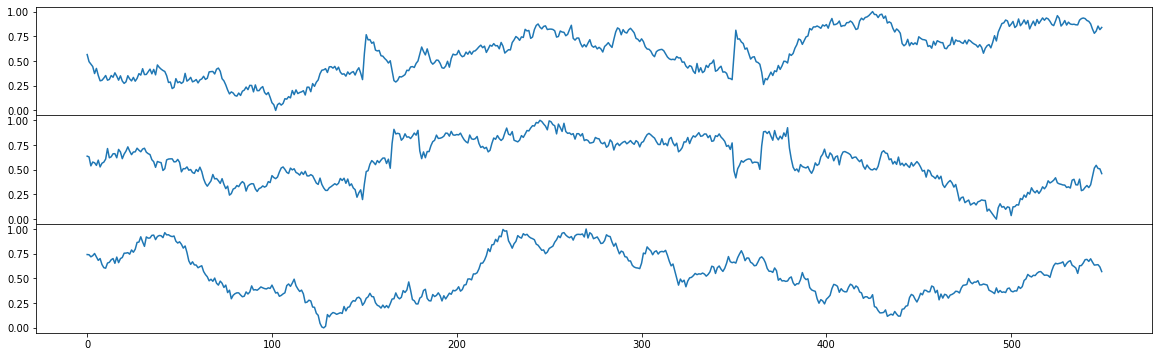

In [4]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(df['T1'])
axs[1].plot(df['T2'])
axs[2].plot(df['T3'])

In [5]:
m = 30
mp_T1 = stumpy.stump(df['T1'], m)

Text(0.5, 0, 'Time')

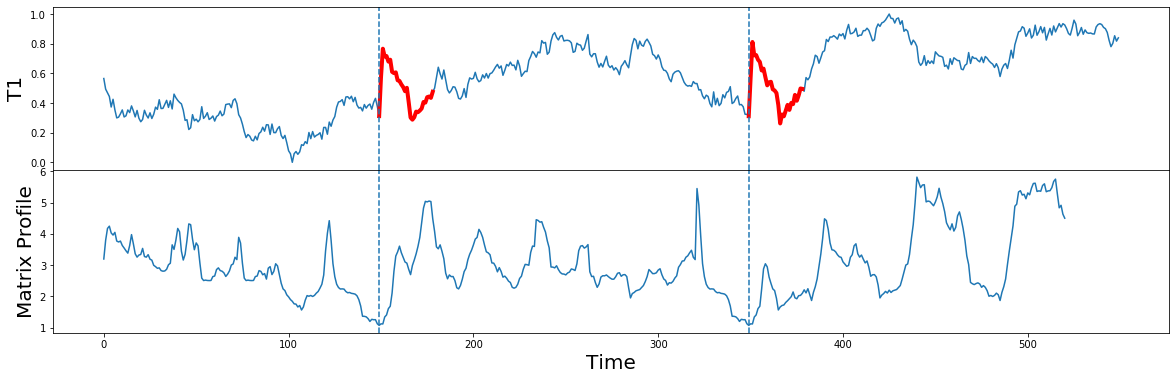

In [6]:
motif_idx = np.argpartition(mp_T1[:, 0], 2)[:2]

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_ylabel('T1', fontsize='20')
axs[0].plot(df['T1'])
for idx in motif_idx:
    axs[0].plot(df['T1'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[0].axvline(x=idx, linestyle="dashed")
    axs[1].axvline(x=idx, linestyle="dashed")
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].plot(mp_T1[:, 0])
axs[1].set_xlabel('Time', fontsize ='20')

In [7]:
mp, indices = stumpy.mstump(df[['T1', 'T2', 'T3']], m)

Text(0.5, 0, 'Time')

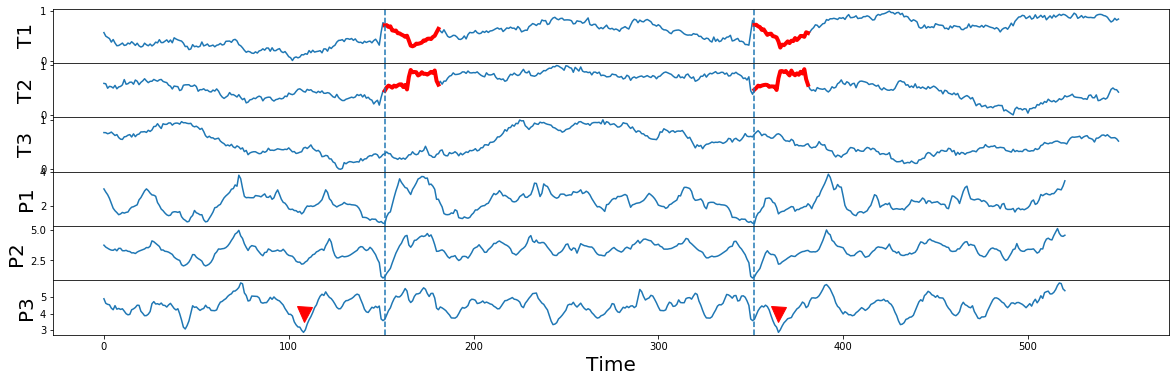

In [10]:
motif_idx = np.argpartition(mp[:, 0], 2)[:2]

fig, axs = plt.subplots(6, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_ylabel('T1', fontsize='20')
axs[1].set_ylabel('T2', fontsize='20')
axs[2].set_ylabel('T3', fontsize='20')

axs[0].plot(df['T1'])
axs[1].plot(df['T2'])
axs[2].plot(df['T3'])

for idx in motif_idx:
    axs[0].plot(df['T1'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[1].plot(df['T2'].iloc[idx:idx+m], c='red', linewidth=4)
    for p in range(6):
        axs[p].axvline(x=idx, linestyle="dashed")

axs[3].set_ylabel('P1', fontsize='20')
axs[4].set_ylabel('P2', fontsize='20')
axs[5].set_ylabel('P3', fontsize='20')

axs[3].plot(mp[:, 0])
axs[4].plot(mp[:, 1])
axs[5].plot(mp[:, 2])

motif_idx = np.argpartition(mp[:, 2], 2)[:2]
for idx in motif_idx:
    plt.plot(idx, 4, marker="v", markersize=15, color='red')

axs[5].set_xlabel('Time', fontsize ='20')